# Data structures

**Author(s)**: Jukka Aho

**Abstract**: Description of data structures.

## Revision history

### 2015-06-14
- Initial version.

### 2015-09-25
- Complete rewrite. The main ideas proposed in earlier version didn't work.

## Data fields on elements

Typical element structure so far:

    type MySuperElement <: Element
        connectivity :: Array{Int, 1}  # describes how dofs of this element is connected to another elements
        fields :: ???
    end

- Fields must be interpolable, in space $\mathbb{C}^n \times \mathbb{R}$, i.e. $f(\boldsymbol{\xi}, t) = \sum_i \phi_i(\boldsymbol{\xi}) f_i(t) = \sum_i \phi_i(\boldsymbol{\xi}) \sum_j \varphi_j(t) f_{ij}$, where $f_{ij}$ is scalar, tensor or vector defined in element area $e$ by some basis functions $\phi(\boldsymbol{\xi})$ and $\varphi(t)$. Parameter $t$ is normally considered as "time" and $\xi$ is dimensionless coordinate. Parameter $t$ has not necessarily to be time, it could be for example angle $\alpha \in [-2\pi, 2\pi]$ or similar.
- We store mainly three fields, scalar field, vector field, tensor field. Field may or may not be dependent from parameters $\xi$ or $t$.
- $t$ is discretized to several steps $\{t_0, t_1, \ldots, t_n\}$. Each discrete time $t_i$ may contain several iterations until convergence. We want to save and get access to all of this data if needed.
- So in practice we have a set of fields $f(\boldsymbol{\xi})$ over time domain $t$. Typically some fields, like Geometry, is introduced only in time $t_0$. Some other fields, like boundary load, may be "active" only on some time $\hat{t} \subset t$. Some care must be taken of how to extrapolate field variables.
- In the simplest case (simple nonlinear quasistatic analysis), we have for instance $t \in [0, 1]$ where boundary conditions are set in $t_0$ and load is set in $t_1$. We may use adaptive strategies to shorten time if convergence issues araises.

## Without time domain

Without time we have something like this

In [1]:
using ForwardDiff

In [2]:
type Field{T}
    time :: Float64
    increment :: Int64
    values :: Array{T, 1}
end

type Basis
    basis :: Function
    dbasisdxi :: Function
end

In [3]:
function Field(time, values)
    Field(time, 1, values)
end
function Basis(basis)
    Basis(basis, ForwardDiff.jacobian(basis))
end
call(b::Basis, xi) = b.basis(xi)
Base.(:*)(x::Array{Float64, 1}, f::Field) = sum(x .* f.values)
Base.(:*)(b::Basis, f::Field) = (x) -> b(x)*f

* (generic function with 158 methods)

Then we can do something like this

In [4]:
N = Basis((ξ) -> [0.5*(1.0-ξ[1]), 0.5*(1.0+ξ[1])])
u = Field(0.0, [0.0, 1.0])

Field{Float64}(0.0,1,[0.0,1.0])

In [5]:
N([0.0])*u

0.5

or

In [6]:
(N*u)([0.0])

0.5

## Extending to time domain

Next we want to interpolate over time domain. Maybe something like this would do the job:

In [7]:
Base.(:*)(k::Float64, f::Field) = Field(f.time, k*f.values)
u1 = Field(0.0, [0.0, 1.0])
3.0*u1

Field{Float64}(0.0,1,[0.0,3.0])

In [8]:
function Base.(:+)(f1::Field, f2::Field)
    @assert(f1.time == f2.time, "Cannot add fields: time mismatch, $(f1.time) != $(f2.time)")
    Field(f1.time, f1.values + f2.values)
end
u1 = Field(0.0, [0.0, 1.0])
u2 = Field(0.0, [1.0, 2.0])
u1 + u2

Field{Float64}(0.0,1,[1.0,3.0])

In [9]:
u1 = Field(0.0, [0.0, 1.0])
u2 = Field(0.0, [1.0, 2.0])

t = Basis((t) -> [1-t, t])
u = Field[u1, u2]
Base.(:*)(x::Array{Float64, 1}, f::Array{Field}) = sum(x .* f)
Base.(:*)(b::Basis, f::Array{Field}) = (t) -> b(t)*f
(t*u)(0.5)

Field{Float64}(0.0,1,[0.5,1.5])

## Semisummary

Putting this together so far:

In [10]:
ϕ = Basis((ξ) -> [0.5*(1.0-ξ[1]), 0.5*(1.0+ξ[1])])
φ = Basis((t) -> [1-t, t])
u1 = Field(0.0, [0.0, 1.0])
u2 = Field(0.0, [1.0, 2.0])
# interpolate displacement u1 in mid-point ξ=[0.0] on element
(ϕ*u1)([0.0]) # => 0.5
# interpolate displacement field [u1, u2] in time t=0.5
(φ*Field[u1, u2])(0.5) # => Field{Float64}(:displacement,[0.5,1.5])
# interpolate displacement in element area ξ and time t
d(ξ, t) = (ϕ*(φ*Field[u1, u2])(t))(ξ)
d([0.0], 0.5)

1.0

Makes sense, since deformation from $u_1$ to $u_2$ at $t=0.5$ is $\begin{bmatrix}0.5 & 1.5\end{bmatrix}$ and taking the midpoint of this makes exactly $1.0$.

## Towards generalization

So at this point we are able to interpolate $u(\xi)$ in time $t$. This is a set of discrete fields and needs to figure out which fields are needed to interpolate. So we have $u_0, u_1, \ldots, u_i$ fields. Each time needs to be aware of it's time $t_i$.

In [11]:
"""
Return a field in some time t.
"""
function call(fields::Array{Field, 1}, t::Float64)
    if t <= fields[1].time
        return fields[1]
    end
    if t >= fields[end].time
        return fields[end]
    end
    i = length(fields)
    while fields[i].time >= t
        i -= 1
    end
    if fields[i].time == t
        return fields[i]
    end
    #Logging.debug("doing linear interpolation between fields $i and $(i+1)")
    f1 = fields[i]
    t1 = f1.time
    f2 = fields[i+1]
    t2 = f2.time
    dt = t2 - t1
    nw = (t2-t)/dt*f1.values + (t-t1)/dt*f2.values
    f = Field(t, nw)
    return f
end
function call(field::Field, t::Float64)
    Field(t, field.increment, field.values)
end

u1 = Field(0.0, [0.0, 0.0])
u2 = Field(1.0, [1.0, 2.0])
u3 = Field(2.0, [0.5, 1.5])
u = Field[u1, u2, u3]
for f in [u(-Inf), u(0.0), u(0.5), u(1.0), u(1.5), u(2.0), u(Inf)]
    println(f)
end

Field{

Handling of derivatives in multidimensional case

In [12]:
∂(h::Basis) = h.dbasisdxi
diff(h::Basis) = h.dbasisdxi
derivative(h::Basis) = h.dbasisdxi
Base.(:*)(df::Function, fld::Field) = (ξ) -> df(ξ)*fld
Base.length(f::Field) = length(f.values)
Base.getindex(f::Field, i::Int64) = f.values[i]
Base.(:*)(x::Array{Float64, 2}, fld::Field) = sum([fld[i]*x[i,:] for i in 1:length(fld)])

* (generic function with 163 methods)

## Summary

In [13]:
using PyPlot

Float64}(0.0,1,[0.0,0.0])
Field{Float64}(0.0,1,[0.0,0.0])
Field{Float64}(0.5,1,[0.5,1.0])
Field{Float64}(1.0,1,[1.0,2.0])
Field{Float64}(1.5,1,[0.75,1.75])
Field{Float64}(2.0,1,[0.5,1.5])
Field{Float64}(2.0,1,[0.5,1.5])


Interpolate midpoint of some field in function of time, i.e., construct $x(\xi, t)$:

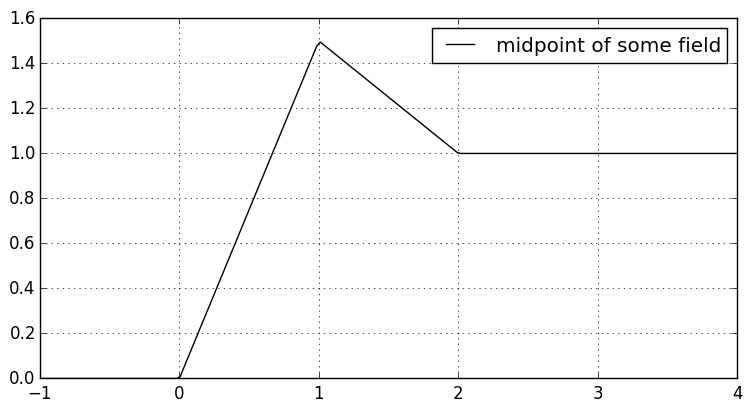

In [14]:
ϕ = Basis((ξ) -> [0.5*(1.0-ξ[1]), 0.5*(1.0+ξ[1])])
u1 = Field(0.0, [0.0, 0.0])
u2 = Field(1.0, [1.0, 2.0])
u3 = Field(2.0, [0.5, 1.5])
u = Field[u1, u2, u3]
x(ξ, t) = ϕ(ξ)*u(t)
t = linspace(-1.0, 4.0, 200)
midpnt = zeros(length(t))
for i =1:length(t)
    midpnt[i] = x([0.0], t[i])
end
plot(t, midpnt, "-k", label="midpoint of some field")
legend()
grid()

Multidimensional interpolation $x(\boldsymbol\xi, t)$:

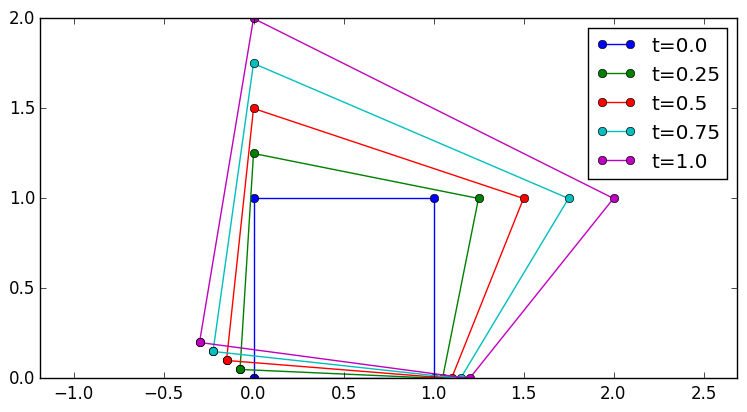

(-0.5,2.0,0.0,2.0)

In [15]:
h = Basis((xi) ->
    [(1-xi[1])*(1-xi[2])/4
     (1+xi[1])*(1-xi[2])/4
     (1+xi[1])*(1+xi[2])/4
     (1-xi[1])*(1+xi[2])/4])
X = Field(0.0, Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]])
u1 = Field(0.0, Vector[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
u2 = Field(1.0, Vector[[-0.3, 0.2], [0.2, 0.0], [1.0, 0.0], [0.0, 1.0]])
u = Field[u1, u2]
N = 5
x(ξ, t) = h(ξ)*(X(t) + u(t))
for t in linspace(0, 1, N)
    m = [x([-1, -1], t) x([1, -1], t) x([1, 1], t) x([-1, 1], t) x([-1, -1], t)]
    midpnt = x([0, 0], t)
    plot(m[1,:][:], m[2,:][:], "-o", label="t=$t")
    #plot(midpnt[1], midpnt[2], "ko")
end
legend()
axis("equal")

To interpolate field $X$ using basis $h$:

In [16]:
(h*X)([0.0, 0.0])

2-element Array{Float64,1}:
 0.5
 0.5

or

In [17]:
h([0.0, 0.0])*X

2-element Array{Float64,1}:
 0.5
 0.5

To interpolate derivatives of field $X$ using basis $h$:

In [18]:
(∂(h)*X)([0.0, 0.0])  # ∂(⋅) is equivalent to diff(⋅) and derivative(⋅)

2x2 Array{Float64,2}:
 0.5  0.0
 0.0  0.5

or

In [19]:
∂(h)([0.0, 0.0])*X

2x2 Array{Float64,2}:
 0.5  0.0
 0.0  0.5